Packages:

In [1]:
%run stdPackages.ipynb
from pyDbs import read, readSets, broadcast
from py.mBasicInt_NonLinear import *
from py.mBasicInt import *
import time

Settings for plotting:

In [2]:
%run PaperPlotting.ipynb
print_pgf()
%matplotlib inline

Read data:

In [3]:
kwargs = {'variables': ['Fundamentals', 'Load', 'Generators_Other'], 
        'variable2D': ['Generators_FuelMix','HourlyVariation'],
        'scalars': ['Scalars'],
        'maps': ['Generators_Categories']}
db = read.dbFromWB(os.path.join(d['data'],'mBasicInt_NonLinear.xlsx'), kwargs)
# db.updateAlias(alias=[('h','h_alias')])
readSets(db)

Define some data handling functions:

In [4]:
def avg_supply(price_matrix,model):
    q = model.hourlyGeneratingCapacity.groupby('id').mean()
    S =[model.simple_CapacityUtilization(x).mul(q).groupby('h').sum().mean() for x in price_matrix]
    return pd.Series(S,index=pd.Index(price_matrix.mean(axis=1),name='Price'),name='Supply')

def avg_demand(price_matrix,model):
    return pd.Series(model.Demand.mean(),index=pd.Index(price_matrix.mean(axis=1),name='Price'),name='Demand')

def smooth_supply(price_matrix,model,σ_grid=None):
    if σ_grid is not None:
        d_S = {}
        for σ in σ_grid:
            m1.sigma = σ
            d_S[σ] = avg_supply(price_matrix,model)
        df = pd.concat([d_S[σ].rename(r'$\sigma=$'+str(σ)) for σ in σ_grid],axis=1)
    else: 
        df = avg_supply(price_matrix,model)
    return df

def kinked_supply(price_matrix,model):
    df_k = pd.concat([model.hourlyGeneratingCapacity.groupby('id').mean().rename('q'), model.averageMC.rename('mc')],axis=1)
    df_k.loc['0'],df_k.loc['-1'] = [0,0], [np.finfo(float).eps,price_matrix.max()]
    df_k = df_k.sort_values('mc')
    df_k['q'] = df_k['q'].cumsum()
    return df_k.set_index('mc').rename_axis('Price')['q'].rename('Supply')
    
# def avg_marg_fuel_consumption(price_matrix,model,unit='level'):
#     if unit=='level':
#         fs ={x.mean(): AvgMarginalFuelConsumption(x,model) for x in price_matrix}
#     elif unit=='share':
#         fs ={x.mean(): AvgMarginalEnergyShare(x,model) for x in price_matrix}        
#     df_fs = pd.concat([pd.Series(fs[x].values,index=pd.MultiIndex.from_product([[x],fs[x].index],names=['Price','Fuel type']),name='Fuel consumption') for x in fs.keys()], axis=0).fillna(0).unstack(level='Fuel type')
#     return df_fs

Define plotting functions:

## 1. Solving simple, small model

Initialize model:

In [5]:
m1 = mSimpleNL(db)

Settings for plotting:

In [6]:
nh =len(m1.db['h'])
p_size = 100
p = np.linspace(0,m1.db['OtherMC'].loc['EDP']*1.6,p_size).repeat(nh).reshape(p_size,nh)
σ_grid = [1,2,10]

Plot smooth supply:

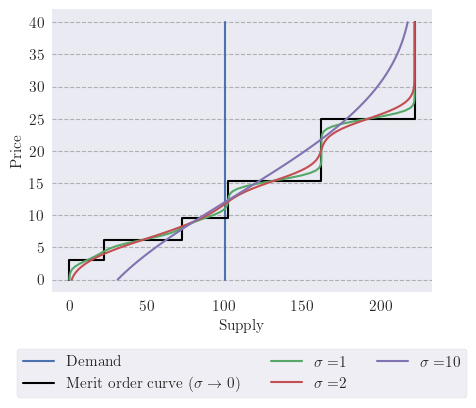

In [7]:
S1 = smooth_supply(p,m1,σ_grid) # Smooth supply:
S2 = kinked_supply(p,m1) # Kinked supply
D = avg_demand(p,m1) # Demand

# Plot:
one_graph()
fig, ax = plt.subplots()
ax.plot(D.values,D.index, label='Demand')
ax.step(S2.values,S2.index,label=r'Merit order curve ($\sigma\rightarrow 0$)',where='pre',color='black')
[ax.plot(S1[col],S1.index,label=col) for col in S1.columns];
ax.set_xlabel('Supply')
ax.set_ylabel('Price')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3, frameon=True)
# fig.savefig(figs_folder+'Total_stocks.pgf',bbox_inches='tight')s

Plot smooth excess demand function:

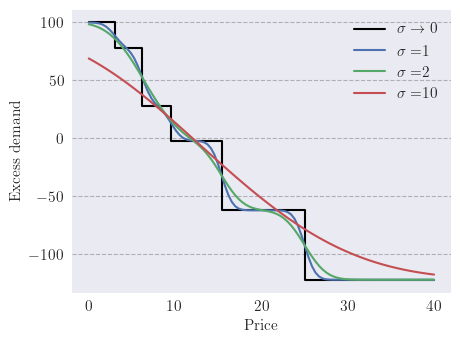

In [8]:
# Data:
D = avg_demand(p,m1)
ED1 = smooth_supply(p,m1,σ_grid).sub(D,axis=0).mul(-1)
ED2 = D.unique()[0] - kinked_supply(p,m1)

# Plot:
one_graph()
fig, ax = plt.subplots()
ax.step(ED2.index.values,ED2.values,label=r'$\sigma\rightarrow 0$',color='black',where='post')
[ax.plot(ED1[col],label=col) for col in ED1.columns];
# ax.hlines(xmin=p.min(),xmax=p.max(),y=0,color='black',linestyle='--',label=r'$F(p)=0$')
ax.set_ylabel('Excess demand')
ax.set_xlabel('Price')
ax.legend(loc=0)

Find equilibrium prices in the corresponding linear programming model:

In [9]:
linear_model = mSimple(db)
linear_model()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


Initial guess for the price vector are the prices from the LP model:

In [10]:
x0 = linear_model.db['marginalSystemCosts'].values
m1.sigma = 2
m1.set_model_parameters() # With a new value of sigma, we need to update some parameters dependent on sigma

Below, we are testing different versions of the model to see the computational gain in making the code more efficient:
1. The first case is the most simple.
3. Next we include an analytical Jacobian matrix of the Excess Demand function used by the scipy solver.
2. Here we exclude machine zeros, which in this model translates into only caring about positive generation.

Ad1) Let's test the `scipy` solver with numerical gradients:

In [11]:
%timeit m1.Solve(x0=x0,update_db=False)

26.5 ms ± 82.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Ad 2) Lets try with the analytical Jacobian such that the scipy solver does not need to estimate it numerically:

In [12]:
%timeit m1.Solve(x0=x0,analyticalJacobian=True,update_db=False)

23.9 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Ad 3) Now, let's test the `scipy` solver when we dummy out zeros and use analytical gradients as well:

In [13]:
m1.model_type = 'no machine zeros' # Here we are changing the model type
%timeit m1.Solve(x0=x0,analyticalJacobian=True,update_db=False)

31.6 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Finally, let's test our own version of the Netwon-Kantorowich solver:

In [14]:
m1.model_type = 'normal'
%timeit m1.Solve(x0=x0,solver='manual',update_db=False)

22 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 2. Solving simple, large model

In [15]:
db = read.dbFromWB(os.path.join(d['data'],'mBasicIntLarge_NonLinear.xlsx'), kwargs)
readSets(db)

Add some moments to the data:

In [16]:
# Multiindex:
mi = db['h'].to_frame(index=False)
mi['Day'] = 0
mi.loc[np.arange(0,8759,24),'Day'] = 1
mi['Day'] = mi['Day'].cumsum()
mi['hDay'] = mi['h']-mi.groupby('Day')['h'].transform('min')
db['h2hDay'] = mi.set_index(['h','hDay']).index

# Average mean emission coefficient per hour the day:
db['hDay'] = pd.Index(db['h2hDay'].get_level_values('hDay').sort_values().unique(),name='hDay')
db['data_emis_coef'] = pd.Series(2,index=db['hDay'],name='data_emis_coef')
db['data'] = db['data_emis_coef'].rename('data')

Initalize model:

In [17]:
linear_model = mSimple(db)
linear_model()
m2 = mSimpleNL(db)
x0 = linear_model.db['marginalSystemCosts'].values
m2.sigma = 0.1
m2.set_model_parameters() # With a new value of sigma, we need to update some parameters dependent on sigma

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


Add targets to model:

In [18]:
m2.Targets = db['data'].astype(float).values

Solve model:

In [ ]:
# m2.model_type = 'normal' # Here we are changing the model type
# tmp = time.time()
# m2.Solve(x0=x0,solver='manual',update_db=False)
# print(time.time()-tmp)
# precise_solution = m2.x.copy()

In [20]:
m2.model_type = 'no machine zeros' # Here we are changing the model type
tmp = time.time()
m2.Solve(x0=x0,solver='manual',update_db=False)
print(time.time()-tmp)
imprecise_solution = m2.x.copy()

8.392797946929932


Verifying accuracy even though removing machine zeroes:

In [ ]:
# (precise_solution==imprecise_solution).all()

In [21]:
σ_grid = [0.1,1,2]
tmp = time.time()
m2.sneakySolve(x0=m2.x, solver='manual',sigma_grid=σ_grid)
m2.postSolve()
print(time.time()-tmp)

45.996540546417236


Check average marginal fuel consumption:

In [22]:
m2.averageMarginalFuelConsumption(m2.x)

p         BFt    
-3.02195  BioMass    3.306561e-20
          Coal       3.336650e-04
          NatGas     1.983862e-08
dtype: float64

In [ ]:
# Data
df_l = avg_marg_fuel_consumption(p,m1)
df_s = avg_marg_fuel_consumption(p,m1,unit='share')

# Plot:
two_graphs()
fig, ax = plt.subplots(ncols=2,nrows=1,layout='constrained') 
df_l.plot(kind='area',ax=ax[0])
df_s.plot(kind='area',ax=ax[1])
ax[0].set_ylabel('MWh')
ax[1].set_ylabel('%')
# ax.legend(loc=0)

Check average marginal energy share of total generation:

In [ ]:
plot_avg_marg_fuel_consumption_share(p,m1)

Check average marginal emissions:

In [ ]:
M = [AvgMarginalEmissions(x,m1).loc['CO2'] for x in p]
M = pd.Series(M,index=pd.Index(p.mean(axis=1),name=r'Price ($p$)'),name='Supply')
fig, ax = plt.subplots()       
M.plot(kind='area',ax=ax)
ax.set_ylabel('Quantity')
ax.legend(loc=0)

Check emissions level:

In [ ]:
m1.db['Emissions']

## Model with cap

New initial conditions:

In [ ]:
m2 = mCap(m1.db.copy())
x0 = np.array(m1.db['p'].tolist()+m1.db['EmissionTax'].tolist())

In [ ]:
x0.shape

In [ ]:
m2.solve(x0=x0)

In [ ]:
m2.emissions(m2.x).loc['CO2']

In [ ]:
m2.db['p']

In [ ]:
m2.db['EmissionTax']

In [ ]:
m2.db['Emissions']

In [ ]:
W1 = m2.db['Welfare']
W1

In [ ]:
m2.ProducerSurplus(m2.x)

Check all equations are solved:

In [ ]:
np.isclose(m2.NonLinearSystem(m2.x).astype(float),b=0).all()

In [ ]:
m2.maximizeWelfare(m2.x)

In [ ]:
m2.db['p']

In [ ]:
np.isclose(m2.NonLinearSystem(m2.x).astype(float),b=0).all()

In [ ]:
m2.db['Welfare']-W1

In [ ]:
m2.db['EmissionTax']

In [ ]:
m2.db['Emissions']

In [ ]:
m2.marginalEconomicCosts(x0)

In [ ]:
m2.hourlyGeneration(m2.x)

In [ ]:
m2.marginalEconomicRevenue(m2.x)